# Setting up

In [4]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report

In [5]:
# load data
data = pd.read_csv('fake_job_postings.csv')

In [6]:
# drop job id column
data.drop('job_id', axis=1, inplace=True)

In [7]:
# view data
data

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0
17876,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0
17878,Graphic Designer,"NG, LA, Lagos",NaN,NaN,NaN,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0


# Feature Extraction and Preprocessing

In [8]:
# extract location
location = data[['location']]

In [9]:
# create column for country
country = []
for i in range(len(location)):
    if type(location.iloc[i].values[0]) == str:
        country.append(location.iloc[i].values[0].split(', ')[0].strip())
    else:
        country.append('')

In [10]:
# append column to dataframe
data['country'] = country

In [11]:
# create column for city
city = []
for i in range(len(location)):
    if type(location.iloc[i].values[0]) == str:
        if len(location.iloc[i].values[0].split(',')) == 3:
            if len(location.iloc[i].values[0].split(',')[-1].strip()) > 2:
                if location.iloc[i].values[0].split(',')[-1] != ' ':
                    city.append(location.iloc[i].values[0].split(',')[-1].strip())
                elif location.iloc[i].values[0].split(',')[-1] == ' ':
                    city.append('')
                elif location.iloc[i].values[0].split(',')[-1] == '  ':
                    city.append('')
            elif len(location.iloc[i].values[0].split(',')[-1].strip()) == 2:
                city.append('')
            elif len(location.iloc[i].values[0].split(',')[-1].strip()) < 2:
                city.append('')
        elif len(location.iloc[i].values[0].split(',')) != 3:
            city.append('')
    else:
        city.append('')

In [12]:
# append column to dataframe
data['city'] = city

In [13]:
# drop location
data.drop(columns=['location'], inplace = True)

In [14]:
# create new variables for salary lower range and salary upper range
salary_range_lower = []
salary_range_upper = []
for i in range(len(data)):
    if type(data['salary_range'].iloc[i]) == str:
        sal = data['salary_range'].iloc[i]
        sal_list = sal.split('-')
        if sal_list[0].isdigit() == True and sal_list[-1].isdigit() == True:
            salary_range_lower.append(int(sal_list[0]))
            salary_range_upper.append(int(sal_list[-1]))
        else:
            salary_range_lower.append(0)
            salary_range_upper.append(0)
    else:
        salary_range_lower.append(0)
        salary_range_upper.append(0)

In [15]:
# add columns to dataframe
data['salary_range_lower'] = salary_range_lower
data['salary_range_upper'] = salary_range_upper

In [16]:
# drop column
data.drop(columns=['salary_range'], inplace = True)

In [17]:
# see where there is missing data
data.isna().sum()

title                      0
department             11547
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
country                    0
city                       0
salary_range_lower         0
salary_range_upper         0
dtype: int64

In [18]:
# fill in nans with an empty string
fill_cols = ['benefits', 'employment_type', 'required_experience', 'required_education',
             'industry', 'function', 'department', 'company_profile', 'description',
             'requirements']
for i in fill_cols:
    data[i] = data[i].fillna('')

In [19]:
# view data
data

,title,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country,city,salary_range_lower,salary_range_upper
0,Marketing Intern,Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,,,Marketing,0,US,New York,0,0
1,Customer Service - Cloud Video Production,Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,,Marketing and Advertising,Customer Service,0,NZ,Auckland,0,0
2,Commissioning Machinery Assistant (CMA),,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,,,,,,0,US,Wever,0,0
3,Account Executive - Washington DC,Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,Washington,0,0
4,Bill Review Manager,,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,Fort Worth,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,Account Director - Distribution,Sales,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,,Computer Software,Sales,0,CA,Toronto,0,0
17876,Payroll Accountant,Accounting,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0,US,Philadelphia,0,0
17877,Project Cost Control Staff Engineer - Cost Con...,,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,,0,0,0,Full-time,,,,,0,US,Houston,0,0
17878,Graphic Designer,,,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0,NG,Lagos,0,0


In [20]:
# double-checking that there is no missing data 
data.isna().sum()

title                  0
department             0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
country                0
city                   0
salary_range_lower     0
salary_range_upper     0
dtype: int64

In [21]:
# tfidf features
data['combined_text'] = data['company_profile'] + " " + data['title'] + " " + data['description'] + " " + data['department'] + " " + data['requirements'] + " " + data['benefits'] + " " + data['department'] + " " + data['country'] + " " + data['city'] 

In [22]:
# clean up combined text
# lower case, remove punctuation, stemming

In [23]:
data

,title,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country,city,salary_range_lower,salary_range_upper,combined_text
0,Marketing Intern,Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,,,Marketing,0,US,New York,0,0,"We're Food52, and we've created a groundbreaki..."
1,Customer Service - Cloud Video Production,Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,,Marketing and Advertising,Customer Service,0,NZ,Auckland,0,0,"90 Seconds, the worlds Cloud Video Production ..."
2,Commissioning Machinery Assistant (CMA),,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,,,,,,0,US,Wever,0,0,Valor Services provides Workforce Solutions th...
3,Account Executive - Washington DC,Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,Washington,0,0,Our passion for improving quality of life thro...
4,Bill Review Manager,,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,Fort Worth,0,0,SpotSource Solutions LLC is a Global Human Cap...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,Account Director - Distribution,Sales,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,,Computer Software,Sales,0,CA,Toronto,0,0,Vend is looking for some awesome new talent to...
17876,Payroll Accountant,Accounting,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0,US,Philadelphia,0,0,WebLinc is the e-commerce platform and service...
17877,Project Cost Control Staff Engineer - Cost Con...,,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,,0,0,0,Full-time,,,,,0,US,Houston,0,0,We Provide Full Time Permanent Positions for m...
17878,Graphic Designer,,,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0,NG,Lagos,0,0,Graphic Designer Nemsia Studios is looking fo...


In [24]:
# one hot encoding
cat_cols = ["employment_type", "required_experience", "required_education", "industry", "function"]
for c in cat_cols:
    encoded = pd.get_dummies(data[c])
    data = pd.concat([data, encoded], axis=1)

In [25]:
data

,title,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,...,Public Relations,Purchasing,Quality Assurance,Research,Sales,Science,Strategy/Planning,Supply Chain,Training,Writing/Editing
0,Marketing Intern,Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,...,0,0,0,0,0,0,0,0,0,0
1,Customer Service - Cloud Video Production,Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,...,0,0,0,0,0,0,0,0,0,0
2,Commissioning Machinery Assistant (CMA),,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,,...,0,0,0,0,0,0,0,0,0,0
3,Account Executive - Washington DC,Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,...,0,0,0,0,1,0,0,0,0,0
4,Bill Review Manager,,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,Account Director - Distribution,Sales,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,...,0,0,0,0,1,0,0,0,0,0
17876,Payroll Accountant,Accounting,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,...,0,0,0,0,0,0,0,0,0,0
17877,Project Cost Control Staff Engineer - Cost Con...,,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,,0,0,0,Full-time,...,0,0,0,0,0,0,0,0,0,0
17878,Graphic Designer,,,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# clean up dataframe
drop_cols = ['company_profile', 'description', 'department', 'requirements', 'benefits', 'department', 'country','city']
data.drop(columns=drop_cols, inplace=True)
data.drop(columns=cat_cols, inplace=True)
data.replace({False: 0, True: 1}, inplace=True)

In [27]:
data

,title,telecommuting,has_company_logo,has_questions,fraudulent,salary_range_lower,salary_range_upper,combined_text,,Contract,...,Public Relations,Purchasing,Quality Assurance,Research,Sales,Science,Strategy/Planning,Supply Chain,Training,Writing/Editing
0,Marketing Intern,0,1,0,0,0,0,"We're Food52, and we've created a groundbreaki...",0,0,...,0,0,0,0,0,0,0,0,0,0
1,Customer Service - Cloud Video Production,0,1,0,0,0,0,"90 Seconds, the worlds Cloud Video Production ...",0,0,...,0,0,0,0,0,0,0,0,0,0
2,Commissioning Machinery Assistant (CMA),0,1,0,0,0,0,Valor Services provides Workforce Solutions th...,1,0,...,0,0,0,0,0,0,0,0,0,0
3,Account Executive - Washington DC,0,1,0,0,0,0,Our passion for improving quality of life thro...,0,0,...,0,0,0,0,1,0,0,0,0,0
4,Bill Review Manager,0,1,1,0,0,0,SpotSource Solutions LLC is a Global Human Cap...,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,Account Director - Distribution,0,1,1,0,0,0,Vend is looking for some awesome new talent to...,0,0,...,0,0,0,0,1,0,0,0,0,0
17876,Payroll Accountant,0,1,1,0,0,0,WebLinc is the e-commerce platform and service...,0,0,...,0,0,0,0,0,0,0,0,0,0
17877,Project Cost Control Staff Engineer - Cost Con...,0,0,0,0,0,0,We Provide Full Time Permanent Positions for m...,0,0,...,0,0,0,0,0,0,0,0,0,0
17878,Graphic Designer,0,0,1,0,0,0,Graphic Designer Nemsia Studios is looking fo...,0,1,...,0,0,0,0,0,0,0,0,0,0


# Modeling

## Logistic Regression using TFIDF

In [28]:
tfidf = TfidfVectorizer(max_features=500, norm='l2', stop_words = 'english')

In [29]:
tfidf_matrix = tfidf.fit_transform(data['combined_text'])

In [30]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
tfidf_df

,000,10,100,30,ability,able,abroad,access,account,accounting,...,windows,word,work,working,world,writing,written,year,years,york
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.063137,0.084245,0.000000,0.000000,0.000000,0.000000,0.000000,0.330545
1,0.128218,0.000000,0.051190,0.049346,0.014530,0.017294,0.0,0.0,0.024763,0.000000,...,0.0,0.000000,0.029061,0.077552,0.065915,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.077301,0.060635,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.029195,0.000000,0.0,0.0,0.497574,0.000000,...,0.0,0.000000,0.058392,0.000000,0.132445,0.000000,0.035677,0.038812,0.024853,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.041064,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.023001,0.030691,0.000000,0.000000,0.000000,0.000000,0.029369,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,0.044222,0.041728,0.000000,0.000000,0.025056,0.000000,0.0,0.0,0.085407,0.000000,...,0.0,0.000000,0.200456,0.156025,0.056834,0.000000,0.030619,0.000000,0.000000,0.000000
17876,0.000000,0.000000,0.054739,0.000000,0.062148,0.036986,0.0,0.0,0.052960,0.660441,...,0.0,0.000000,0.124301,0.000000,0.000000,0.051153,0.000000,0.000000,0.052905,0.000000
17877,0.000000,0.000000,0.000000,0.000000,0.033151,0.039458,0.0,0.0,0.000000,0.140917,...,0.0,0.000000,0.044203,0.029490,0.000000,0.000000,0.000000,0.000000,0.056441,0.000000
17878,0.000000,0.000000,0.000000,0.000000,0.000000,0.195574,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.054773,0.073085,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [31]:
data

,title,telecommuting,has_company_logo,has_questions,fraudulent,salary_range_lower,salary_range_upper,combined_text,,Contract,...,Public Relations,Purchasing,Quality Assurance,Research,Sales,Science,Strategy/Planning,Supply Chain,Training,Writing/Editing
0,Marketing Intern,0,1,0,0,0,0,"We're Food52, and we've created a groundbreaki...",0,0,...,0,0,0,0,0,0,0,0,0,0
1,Customer Service - Cloud Video Production,0,1,0,0,0,0,"90 Seconds, the worlds Cloud Video Production ...",0,0,...,0,0,0,0,0,0,0,0,0,0
2,Commissioning Machinery Assistant (CMA),0,1,0,0,0,0,Valor Services provides Workforce Solutions th...,1,0,...,0,0,0,0,0,0,0,0,0,0
3,Account Executive - Washington DC,0,1,0,0,0,0,Our passion for improving quality of life thro...,0,0,...,0,0,0,0,1,0,0,0,0,0
4,Bill Review Manager,0,1,1,0,0,0,SpotSource Solutions LLC is a Global Human Cap...,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,Account Director - Distribution,0,1,1,0,0,0,Vend is looking for some awesome new talent to...,0,0,...,0,0,0,0,1,0,0,0,0,0
17876,Payroll Accountant,0,1,1,0,0,0,WebLinc is the e-commerce platform and service...,0,0,...,0,0,0,0,0,0,0,0,0,0
17877,Project Cost Control Staff Engineer - Cost Con...,0,0,0,0,0,0,We Provide Full Time Permanent Positions for m...,0,0,...,0,0,0,0,0,0,0,0,0,0
17878,Graphic Designer,0,0,1,0,0,0,Graphic Designer Nemsia Studios is looking fo...,0,1,...,0,0,0,0,0,0,0,0,0,0


In [32]:
features = data.drop(columns=['fraudulent', 'title', 'combined_text'])


In [33]:
X = features.join(tfidf_df)
y = data[['fraudulent']]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [35]:
y_train = y_train.values.reshape(len(y_train), )
y_test = y_test.values.reshape(len(y_test), )

In [36]:
clf = LogisticRegression(max_iter = 5000).fit(X_train, y_train)

In [37]:
y_pred = clf.predict(X_test)

In [38]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report

In [39]:
# accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9521812080536913


In [40]:
# precision
precision = precision_score(y_test, y_pred, average='weighted')
print("Precision:", precision)

Precision: 0.906649052970587


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
# recall
recall = recall_score(y_test, y_pred, average='weighted')
print("Recall:", recall)

Recall: 0.9521812080536913


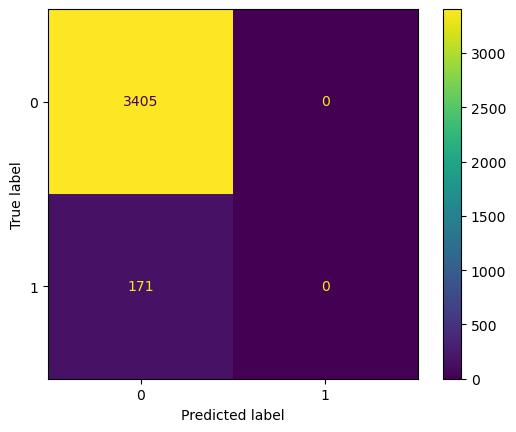

In [42]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plot confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      3405
           1       0.00      0.00      0.00       171

    accuracy                           0.95      3576
   macro avg       0.48      0.50      0.49      3576
weighted avg       0.91      0.95      0.93      3576



D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
